In [213]:
import pandas as pd
import numpy as np
import pyodbc as py

from datetime import date, timedelta, datetime
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn import neighbors
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
#from tensorflow.keras.utils import np_utils

import functions

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('/Users/LV/Desktop/data_bol_complete.csv', low_memory = True)

In [6]:
df['orderDate'] = pd.to_datetime(df['orderDate'])
df['cancellationDate'] = pd.to_datetime(df['cancellationDate'])
df['promisedDeliveryDate'] = pd.to_datetime(df['promisedDeliveryDate'])
df['shipmentDate'] = pd.to_datetime(df['shipmentDate'])
df['dateTimeFirstDeliveryMoment'] = pd.to_datetime(df['dateTimeFirstDeliveryMoment'])
df['startDateCase'] = pd.to_datetime(df['startDateCase'])
df['returnDateTime'] = pd.to_datetime(df['returnDateTime'])
df['registrationDateSeller'] = pd.to_datetime(df['registrationDateSeller'])

#### Models

In [194]:
#Fixed Columns:
DATE = ['orderDate']
BASIC = ['totalPrice','quantityOrdered','fulfilmentByBol','countryCodeNL','countryOriginNL','countryOriginBE',
        'countryOriginDE','productTitleLength','promisedDeliveryDays','partnerSellingMonths']
WEEK = ['orderMonday','orderTuesday','orderWednesday','orderThursday','orderFriday','orderSaturday','orderSunday']
MONTH = ['orderJanuary','orderFebruary','orderMarch','orderApril','orderMay','orderJune',
         'orderJuly','orderAugust','orderSeptember','orderOctober','orderNovember','orderDecember']
YEAR = ['orderYear2019','orderYear2020']
GROUP = ['groupHealth','groupHome','groupSports','groupComputer','groupPets','groupToys','groupBooks', 
         'groupBaby', 'groupMusic', 'groupFood','groupOffice','groupFashion','groupOther','groupCar']

#Dynamic Columns:
TRANSPORTERX = ['transporterPOSTNL/X','transporterDHL/X','transporterDPD/X','transporterBRIEF/X','transporterOTHER/X']
KNOWNX = ['caseKnownX','returnKnownX','cancellationKnownX','onTimeDeliveryKnownX','lateDeliveryKnownX']
PRODUCTX = ['productOrderCountX','productTotalCountX','productTotalReturnedX','productReturnFractionX']
SELLERX = ['sellerDailyOrdersX']

#Determinants
DETERMINANT = ['noReturn','noCase','noCancellation','onTimeDelivery']

#Classifications
CLASSIFICATION = ['generalMatchClassification','detailedMatchClassification','binaryMatchClassification','determinantClassification']

In [237]:
X_col = BASIC + WEEK + MONTH + YEAR + GROUP + TRANSPORTERX + KNOWNX #+ SELLERX + PRODUCTX 
Y_col = [CLASSIFICATION[0]]

df_ = df.sample(n=100000, replace=False, random_state=1)
X, y = dataX(df_,0)

train_index = X.iloc[:80000].index
test_index = X.iloc[80000:].index

scaler = preprocessing.MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
dummy_y = pd.DataFrame(np_utils.to_categorical(encoded_y))
y_train, y_test = dummy_y.iloc[train_index], dummy_y.iloc[test_index]

In [238]:
model = Sequential()

model.add(Dense(units=30,activation='relu'))
model.add(Dense(units=3,activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.fit(X_train, y_train, 
          validation_data = (X_test, y_test),
          epochs = 20)

Epoch 1/20
2500/2500 [==============================] - 4s 2ms/step - loss: 0.7283 - accuracy: 0.7067 - val_loss: 0.6272 - val_accuracy: 0.7649
Epoch 2/20
2500/2500 [==============================] - 3s 1ms/step - loss: 0.6312 - accuracy: 0.7617 - val_loss: 0.6194 - val_accuracy: 0.7710
Epoch 3/20
2500/2500 [==============================] - 4s 1ms/step - loss: 0.6179 - accuracy: 0.7678 - val_loss: 0.6117 - val_accuracy: 0.7766
Epoch 4/20
2500/2500 [==============================] - 5s 2ms/step - loss: 0.6120 - accuracy: 0.7686 - val_loss: 0.6091 - val_accuracy: 0.7802
Epoch 5/20
2500/2500 [==============================] - 4s 2ms/step - loss: 0.6075 - accuracy: 0.7720 - val_loss: 0.6114 - val_accuracy: 0.7755
Epoch 6/20
2500/2500 [==============================] - 3s 1ms/step - loss: 0.6036 - accuracy: 0.7741 - val_loss: 0.6159 - val_accuracy: 0.7728
Epoch 7/20
2500/2500 [==============================] - 3s 1ms/step - loss: 0.6047 - accuracy: 0.7716 - val_loss: 0.6065 - val_accuracy:

<AxesSubplot:>

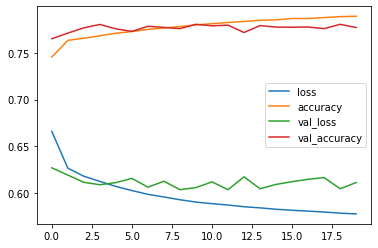

In [239]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

NameError: name 'classification_report' is not defined

In [193]:
# Decision Tree
X_col = BASIC + WEEK + MONTH + YEAR + GROUP #+ TRANSPORTERX + KNOWNX + PRODUCTX + SELLERX
Y_col = [CLASSIFICATION[0]]

df_ = df.sample(n=100000, replace=False, random_state=1)

PREDICT_DAYS = 5
REP = 3

resultsAcc = {}
resultsClass = {}

for DAYS in range(PREDICT_DAYS):
    
    X, y = dataX(df_,DAYS)

    accuracy, class_report = classifyLabels(RandomForestClassifier(n_estimators=10,
                                                                random_state=0,
                                                                class_weight='balanced'), X, y, n = REP)

    resultsAcc[DAYS] = accuracy
    resultsClass[DAYS] = class_report
    
    print('DAYS: ',DAYS)

NameError: name 'np' is not defined

In [164]:
accuracy = {k: sum(v.values())/len(v.values()) for k, v in resultsAcc.items()}

labels = {}

for CLASS in ['KNOWN HAPPY','UNHAPPY','UNKNOWN']:
    precision = {}
    for DAYS in range(PREDICT_DAYS):
        summ = 0
        for rep in range(REP):
            summ += resultsClass[DAYS][rep+1][CLASS]['recall']
        avg = summ / REP
        precision[DAYS] = avg
    labels[CLASS] = precision

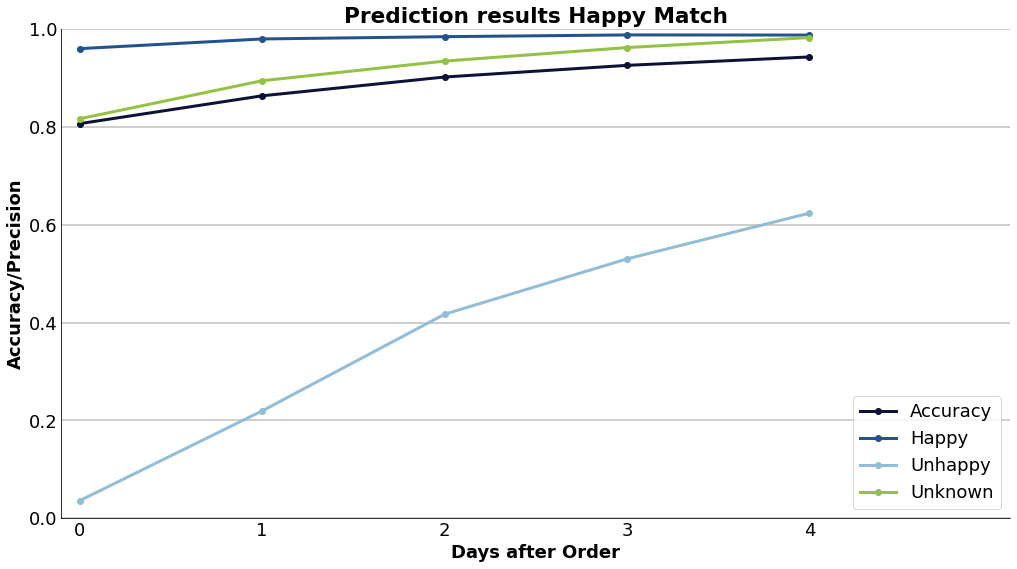

In [165]:
### Plot parameters
plt.rcParams.update({'font.size': 18})

# Turn interactive plotting off
plt.ioff()

### Plotten
plt.figure(figsize = (17,9))

x1,y1 = zip(*sorted(accuracy.items()))
x2,y2 = zip(*sorted(labels['KNOWN HAPPY'].items()))
x3,y3 = zip(*sorted(labels['UNHAPPY'].items()))
x4,y4 = zip(*sorted(labels['UNKNOWN'].items()))

plt.plot(x1,y1, color='#0e1236', marker = 'o', linewidth=3)
plt.plot(x2,y2, color='#21538e', marker = 'o', linewidth=3)
plt.plot(x3,y3, color='#92bdd8', marker = 'o', linewidth=3)
plt.plot(x4,y4, color='#93c244', marker = 'o', linewidth=3)

### Titel
plt.title('Prediction results Happy Match', fontweight = 'bold')

### Assen
plt.ylabel('Accuracy/Precision', fontweight = 'bold')
plt.ylim(0, 1)
plt.xlabel('Days after Order', fontweight = 'bold')
plt.xlim(-0.1,5.1)
plt.xticks(x1)

### Grafiek Lay-out
plt.grid(color='#C0C0C0', linestyle='-', linewidth=1.5, axis = 'y')
plt.legend(('Accuracy', 'Happy', 'Unhappy', 'Unknown'),loc='lower right')
plt.tick_params(direction='out', length=0, colors='black')
sns.despine(left=False, bottom=False, right=True)
plt.show()

#### Functions

In [236]:
def dataX(df,days):
    
    df = functions.addKnownColumns(df,days)
#     df = functions.addProductColumns(df,days)
#     df = functions.addSellerColumns(df,days)
    
    df = df[DATE + X_col + Y_col]
    
    df = df.dropna()
    df = df.sort_values(by = 'orderDate')
    df = df.reset_index(drop = True)
    
    X = df[X_col]
    y = df[Y_col]
    
    return(X,y)

In [175]:
def classifyLabels(classifier, X, y, n, split = 'TimeSeries', smote = False, scale = None, days = 0):
    """
    Function to classify match labels using a pre-specified classifier with X and y variables. 
    
    Input:
    - classifier: can be any supported classifier. E.g. DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth=10). Necessary!
    - X: dataframe input on explanatory features. Necessary!
    - y: dataframe input on labels. Necessary!
    - n: number of folds to be evaluated.
    - split: object that can take value 'Random' to make K-fold random train/test split. Default is to apply time series split.
    - smote: boolean, if true Synthetic Minority Oversampling will be applied. Default = False.
    - scale: object that can take values 'MinMax' or 'Standard' to scale X correspondingly. Any other input will not scale X. Default = None.
    - days: integer number of days after orderDate that should be considered. Default = 0.
    
    Output: 
    - accuracy: list of accuracies for the n evaluated classifiers.
    - class_report: report of performance measures for the n evaluated classifiers.
    """
    
    accuracy = {}
    class_report = {}
    count = 1
    
    if split == 'Random':
        
        kf = StratifiedKFold(n_splits = n, random_state = 0, shuffle = True)
        for train_index, test_index in kf.split(X, y):

            if scale == 'MinMax':
                scaler = preprocessing.MinMaxScaler()
                X_scaled = pd.DataFrame(scaler.fit_transform(X))
                X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            elif scale == 'Standard':
                scaler = preprocessing.StandardScaler()
                X_scaled = pd.DataFrame(scaler.fit_transform(X))
                X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            else:
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            if smote == True:
                smote = SMOTE('not majority')
                X_train, y_train = smote.fit_sample(X_train,y_train)
            else:
                X_train, y_train = X_train, y_train
            
            clf = classifier
            clf = clf.fit(X_train,y_train)
            prediction = clf.predict(X_test)
            accuracy[count] = metrics.accuracy_score(y_test, prediction)
            class_report[count] = metrics.classification_report(y_test, prediction,output_dict=True)
            
            #print(count)
            count +=1
    
    else:
        
        tscv = TimeSeriesSplit(n_splits = n)
        
        for train_index, test_index in tscv.split(X):
        
            if scale == 'MinMax':
                scaler = preprocessing.MinMaxScaler()
                X_scaled = pd.DataFrame(scaler.fit_transform(X))
                X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            elif scale == 'Standard':
                scaler = preprocessing.StandardScaler()
                X_scaled = pd.DataFrame(scaler.fit_transform(X))
                X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            else:
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            if smote == True:
                smote = SMOTE('not majority')
                X_train, y_train = smote.fit_sample(X_train,y_train)
            else:
                X_train, y_train = X_train, y_train
            
            clf = classifier
            clf = clf.fit(X_train,y_train)
            prediction = clf.predict(X_test)
            accuracy[count] = metrics.accuracy_score(y_test, prediction)
            class_report[count] = metrics.classification_report(y_test, prediction,output_dict=True)
    
            #print(count)
            count +=1
            
#             plt.rcParams.update({'font.size': 10})
#             importanceDF = pd.DataFrame(clf.feature_importances_,index=X_col,columns=['importance']).sort_values('importance',ascending=False)
#             importanceDF.plot.bar(figsize=(16,8))
#             plt.show()

    return(accuracy, class_report)